## Collaborative Filtering

These notebook will compare the performance of _Neural Collaborative Filtering_ **[1]** and _Neural Graph Collaborative Filtering_ **[2]** papers on MovieLens dataset. We would like to see if there is a difference between non-graph based method and a graph-based method on collaborative filtering using MovieLens dataset. We will benefit from [this GitHub repository](https://github.com/talkingwallace/NGCF-pytorch/blob/master/GraphNCF/GCFmodel.py) **[3]** for the implementation of these two models.

__Neural Collaborative Filtering:__ When it comes to model the key factor in collaborative filtering -- the interaction between user and item features, they still resorted to matrix factorization and applied an inner product on the latent features of users and items. By replacing the inner product with a neural architecture that can learn an arbitrary function from data, we present a general framework named NCF, short for Neural network-based Collaborative Filtering.

__Neural Graph Collaborative Filtering:__ In this work, we propose to integrate the user-item interactions --- more specifically the bipartite graph structure --- into the embedding process. We develop a new recommendation framework Neural Graph Collaborative Filtering (NGCF), which exploits the user-item graph structure by propagating embeddings on it.

***

### Libraries

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import MSELoss
import time

np.random.seed(23)

In [24]:
!git clone https://github.com/Movinder/movielens-imdb-exploration.git


fatal: destination path 'movielens-imdb-exploration' already exists and is not an empty directory.


### Data Preprocessing

In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RatingsDataset(Dataset):
    """Ratings Dataset"""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with ratings.
        """
        self.csv = pd.read_csv('/content/movielens-imdb-exploration/data/ratings.csv')

        self.user_ids = list(self.csv.user_id-1)
        self.movie_ids = list(self.csv.movie_id_ml-1)
        self.ratings = list(self.csv.rating)

        self.userNums = np.max(self.user_ids)+1
        self.movieNums = np.max(self.movie_ids)+1

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return {
            'user': self.user_ids[idx],
            'movie': self.movie_ids[idx],
            'rating': self.ratings[idx]
        }

    def get_user_number(self):
        return self.userNums

    def get_movie_number(self):
        return self.movieNums

In [26]:
rt = pd.read_csv('/content/movielens-imdb-exploration/data/ratings.csv')
rt['user_id'] = rt['user_id'] - 1
rt['movie_id_ml'] = rt['movie_id_ml'] - 1

dataset = RatingsDataset()

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(len(dataset))

100000


### Model Implementation - Neural Collaborative Filtering

In [27]:
class NCF(Module):

    def __init__(self, userNum, itemNum, dim=64, first_layer=128):
        super(NCF, self).__init__()

        self.uEmbd = nn.Embedding(userNum, dim)
        self.iEmbd = nn.Embedding(itemNum, dim)

        self.mf_uEmbd = nn.Embedding(userNum, dim)
        self.mf_iEmbd = nn.Embedding(itemNum, dim)

        self.mlp = nn.Sequential(nn.Linear(dim*2, first_layer),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer, first_layer//2),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//2, first_layer//4),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//4, first_layer//4))

        self.neumf = nn.Linear(dim+first_layer//4, 1)

    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)

        mlp = self.mlp(embd)
        mf = self.uEmbd(userIdx)*self.iEmbd(itemIdx)

        prediction = self.neumf(torch.cat([mlp, mf], dim=1))

        return prediction.flatten()

### Model Implementation - Neural Graph Collaborative Filtering

In [28]:
class GNNLayer(Module):

    def __init__(self,inF,outF):

        super(GNNLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.linear = torch.nn.Linear(in_features=inF,out_features=outF)
        self.interActTransform = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, laplacianMat,selfLoop,features):
        L1 = laplacianMat + selfLoop
        L2 = laplacianMat.cuda()
        L1 = L1.cuda()
        inter_feature = torch.mul(features,features)

        inter_part1 = self.linear(torch.sparse.mm(L1,features))
        inter_part2 = self.interActTransform(torch.sparse.mm(L2,inter_feature))

        return inter_part1+inter_part2

class NGCF(Module):

    def __init__(self,userNum,itemNum,rt,embedSize=100,layers=[100,80,50],useCuda=True):

        super(NGCF,self).__init__()
        self.useCuda = useCuda
        self.userNum = userNum
        self.itemNum = itemNum
        self.uEmbd = nn.Embedding(userNum,embedSize)
        self.iEmbd = nn.Embedding(itemNum,embedSize)
        self.GNNlayers = torch.nn.ModuleList()
        self.LaplacianMat = self.buildLaplacianMat(rt) # sparse format
        self.selfLoop = self.getSparseEye(self.userNum+self.itemNum)

        self.transForm1 = nn.Linear(in_features=layers[-1]*(len(layers))*2,out_features=64)
        self.transForm2 = nn.Linear(in_features=64,out_features=32)
        self.transForm3 = nn.Linear(in_features=32,out_features=1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.GNNlayers.append(GNNLayer(From,To))

    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)

    def buildLaplacianMat(self,rt):

        rt_item = rt['movie_id_ml'] + self.userNum
        uiMat = coo_matrix((rt['rating'], (rt['user_id'], rt['movie_id_ml'])))

        uiMat_upperPart = coo_matrix((rt['rating'], (rt['user_id'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.itemNum, self.userNum + self.itemNum))

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.userNum+self.itemNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(i,data)
        return SparseL

    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.useCuda == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()

        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)
        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features

    def forward(self,userIdx,itemIdx):

        itemIdx = itemIdx + self.userNum
        userIdx = list(userIdx.cpu().data)
        itemIdx = list(itemIdx.cpu().data)
        # gcf data propagation
        features = self.getFeatureMat()
        finalEmbd = features.clone()
        for gnn in self.GNNlayers:
            features = gnn(self.LaplacianMat,self.selfLoop,features)
            features = nn.LeakyReLU()(features)
            finalEmbd = torch.cat([finalEmbd,features.clone()],dim=1)

        userEmbd = finalEmbd[userIdx]
        itemEmbd = finalEmbd[itemIdx]
        embd = torch.cat([userEmbd,itemEmbd],dim=1)

        embd = nn.ReLU()(self.transForm1(embd))
        embd = nn.ReLU()(self.transForm2(embd))
        embd = self.transForm3(embd)
        prediction = embd.flatten()

        return prediction

### Training

In [29]:
def train(loader, model, optim, loss):
    model.train()
    ls = 0.

    for id, batch in enumerate(loader):
        optim.zero_grad()
        prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
        loss_ = loss(batch['rating'].float().cuda(0), prediction)
        loss_.backward()
        optim.step()
        ls += loss_.item()

    return ls / len(loader)


def evaluate(loader, model, loss):
    model.eval()
    ls = 0.

    with torch.no_grad():
        for id, batch in enumerate(loader):
            prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
            loss_ = loss(batch['rating'].float().cuda(0), prediction)
            ls += loss_.item()

    return ls / len(loader)

In [30]:
def trainer(trainLoader, valLoader, model, optim, loss, epoch, model_name, verbose=True):

    train_losses = []
    val_losses = []

    best_val = np.inf

    for i in range(epoch):
        start = time.time()
        TL = train(trainLoader, model, optim, loss)
        VL = evaluate(valLoader, model, loss)

        if verbose:
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, TL, VL, (time.time()-start)/60))

        if VL < best_val:
            torch.save(model.state_dict(), model_name + '.pth.tar')
            best_val = VL

        train_losses.append(TL)
        val_losses.append(VL)

    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'min_val_loss': min(val_losses)
    }, model_name + '_loss.pth.tar')

    return torch.load(model_name + '_loss.pth.tar')

### NeuMF Training

In [31]:
# EMBEDDING_DIM = 64

# GRID_SEARCH = {
#     'batch_size': [128, 256, 512],
#     'first_layer': [64, 128, 256],
#     'learning_rate': [1e-3, 1e-2]
# }

In [32]:
# for bs in GRID_SEARCH['batch_size']:
#     for layer in GRID_SEARCH['first_layer']:
#         for lr in GRID_SEARCH['learning_rate']:

#             trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
#             valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

#             model = NCF(dataset.get_user_number(), dataset.get_movie_number(),
#                         dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

#             optim = Adam(model.parameters(), lr=lr)
#             loss = nn.L1Loss()
#             epoch = 20

#             ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

#             print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
#                                                                                                             layer,
#                                                                                                             lr,
#                                                                                                             ncf_out['min_val_loss']))

In [33]:
bs = 128
layer = 64
lr = 0.005
EMBEDDING_DIM = 64

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NCF(dataset.get_user_number(), dataset.get_movie_number(),
            dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

optim = Adam(model.parameters(), lr=lr)
loss = nn.L1Loss()
epoch = 100

nf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
                                                                                                layer,
                                                                                                lr,
                                                                                                nf_out['min_val_loss']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.005 - Min. Val. Loss: 0.7652142433783947


<ipython-input-30-361a62dd9437>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_name + '_loss.pth.tar')


### NGCF Training

In [34]:
# EMBEDDING_DIM = 64

# GRID_SEARCH = {
#     'batch_size': [256, 512, 1024],
#     'layers': [[64,64], [64,64,64], [64,64,64,64]]
# }

In [35]:
# for bs in GRID_SEARCH['batch_size']:
#     for layer in GRID_SEARCH['layers']:

#         trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
#         valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

#         model = NGCF(dataset.get_user_number(), dataset.get_movie_number(), rt, EMBEDDING_DIM, layers=layer).cuda(0)
#         optim = Adam(model.parameters(), lr=1e-3)
#         loss = nn.L1Loss()
#         epoch = 20

#         ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ngcf_model', False)

#         print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
#                                                                                                         layer,
#                                                                                                         lr,
#                                                                                                         ncf_out['min_val_loss']))

In [36]:
bs = 256
layer = [64, 64, 64, 64]

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NGCF(dataset.get_user_number(), dataset.get_movie_number(), rt, EMBEDDING_DIM, layers=layer).cuda(0)
optim = Adam(model.parameters(), lr=1e-3)
loss = nn.L1Loss()
epoch = 100

ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ngcf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
                                                                                                layer,
                                                                                                lr,
                                                                                                ncf_out['min_val_loss']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch Size: 256 | First Layer Neuron: [64, 64, 64, 64] | Learning Rate: 0.005 - Min. Val. Loss: 0.722553435808573


<ipython-input-30-361a62dd9437>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_name + '_loss.pth.tar')


### Training Results

In [37]:
nf_out = torch.load('ncf_model_loss.pth.tar')
ncf_out = torch.load('ngcf_model_loss.pth.tar')

<ipython-input-37-342292d22135>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nf_out = torch.load('ncf_model_loss.pth.tar')
<ipython-input-37-342292d22135>:2: FutureWarni

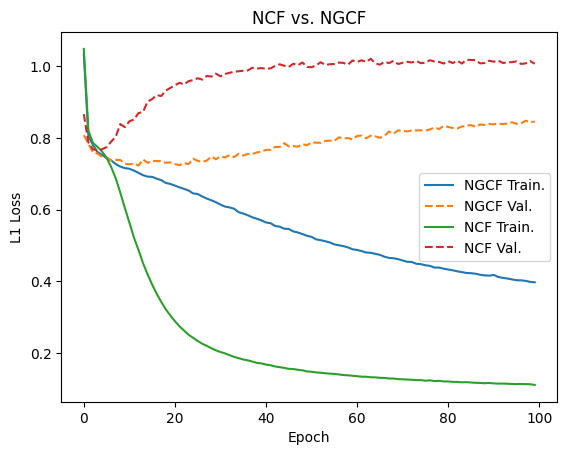

In [38]:
plt.title('NCF vs. NGCF')
plt.plot(ncf_out['train_losses'], label='NGCF Train.')
plt.plot(ncf_out['val_losses'], label='NGCF Val.', linestyle='--')
plt.plot(nf_out['train_losses'], label='NCF Train.')
plt.plot(nf_out['val_losses'], label='NCF Val.', linestyle='--')
_ = plt.ylabel('L1 Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
plt.savefig('ncf_ngcf.png', bbox_inches='tight', dpi=200)

## LightGCN

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader

class LightGCN(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=64, num_layers=3):
        super(LightGCN, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Embeddings for users and movies
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.movie_embedding.weight, std=0.1)

    def forward(self, user_ids, movie_ids):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)

        # Dot product for recommendation score
        scores = torch.sum(user_emb * movie_emb, dim=-1)
        return scores

    # def bpr_loss(self, users, pos_items, neg_items):
    #     user_emb = self.user_embedding(users)
    #     pos_emb = self.movie_embedding(pos_items)
    #     neg_emb = self.movie_embedding(neg_items)

    #     pos_scores = torch.sum(user_emb * pos_emb, dim=-1)
    #     neg_scores = torch.sum(user_emb * neg_emb, dim=-1)

    #     loss = -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))
    #     return loss


In [40]:
# Prepare DataLoaders
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [41]:
# Initialize LightGCN model
embedding_dim = 64
num_users = dataset.get_user_number()
num_movies = dataset.get_movie_number()

model = LightGCN(num_users, num_movies, embedding_dim=embedding_dim).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  #  Loss

# Training loop
epochs = 100
lightgcn_train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        user_ids = batch['user'].to('cuda')
        movie_ids = batch['movie'].to('cuda')
        ratings = batch['rating'].float().to('cuda')  # True ratings

        optimizer.zero_grad()
        predicted_ratings = model(user_ids, movie_ids)
        loss = criterion(predicted_ratings, ratings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
     # Save epoch loss for LightGCN
    epoch_loss = total_loss / len(train_loader)
    lightgcn_train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/100, Loss: 3.5301
Epoch 2/100, Loss: 3.5158
Epoch 3/100, Loss: 3.4947
Epoch 4/100, Loss: 3.4474
Epoch 5/100, Loss: 3.3229
Epoch 6/100, Loss: 3.0110
Epoch 7/100, Loss: 2.3795
Epoch 8/100, Loss: 1.5614
Epoch 9/100, Loss: 1.0811
Epoch 10/100, Loss: 0.8890
Epoch 11/100, Loss: 0.7988
Epoch 12/100, Loss: 0.7498
Epoch 13/100, Loss: 0.7189
Epoch 14/100, Loss: 0.6965
Epoch 15/100, Loss: 0.6783
Epoch 16/100, Loss: 0.6622
Epoch 17/100, Loss: 0.6471
Epoch 18/100, Loss: 0.6332
Epoch 19/100, Loss: 0.6192
Epoch 20/100, Loss: 0.6055
Epoch 21/100, Loss: 0.5925
Epoch 22/100, Loss: 0.5786
Epoch 23/100, Loss: 0.5660
Epoch 24/100, Loss: 0.5534
Epoch 25/100, Loss: 0.5414
Epoch 26/100, Loss: 0.5288
Epoch 27/100, Loss: 0.5168
Epoch 28/100, Loss: 0.5049
Epoch 29/100, Loss: 0.4932
Epoch 30/100, Loss: 0.4821
Epoch 31/100, Loss: 0.4709
Epoch 32/100, Loss: 0.4602
Epoch 33/100, Loss: 0.4500
Epoch 34/100, Loss: 0.4399
Epoch 35/100, Loss: 0.4297
Epoch 36/100, Loss: 0.4203
Epoch 37/100, Loss: 0.4112
Epoch 38/1

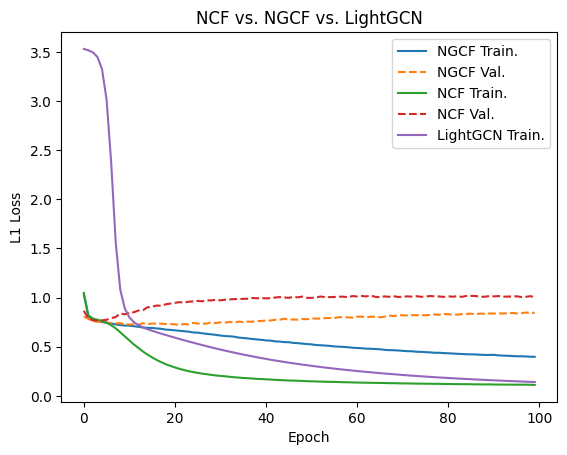

In [42]:
import matplotlib.pyplot as plt

# # Initialize lists to store LightGCN losses
# lightgcn_train_losses = []

# # Training loop
# epochs = 20
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0

#     for batch in train_loader:
#         user_ids = batch['user'].to('cuda')
#         movie_ids = batch['movie'].to('cuda')
#         ratings = batch['rating'].float().to('cuda')  # True ratings

#         optimizer.zero_grad()
#         predicted_ratings = model(user_ids, movie_ids)
#         loss = criterion(predicted_ratings, ratings)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     # Save epoch loss for LightGCN
#     epoch_loss = total_loss / len(train_loader)
#     lightgcn_train_losses.append(epoch_loss)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plot the results
plt.title('NCF vs. NGCF vs. LightGCN')
plt.plot(ncf_out['train_losses'], label='NGCF Train.')
plt.plot(ncf_out['val_losses'], label='NGCF Val.', linestyle='--')
plt.plot(nf_out['train_losses'], label='NCF Train.')
plt.plot(nf_out['val_losses'], label='NCF Val.', linestyle='--')
plt.plot(lightgcn_train_losses, label='LightGCN Train.')  # Use the list of losses
plt.ylabel('L1 Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('ncf_ngcf.png', bbox_inches='tight', dpi=200)
plt.show()


***

## References

[1] _He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. International World Wide Web Conferences Steering Committee, 2017._

[2] _Wang, Xiang, et al. "Neural Graph Collaborative Filtering." arXiv preprint arXiv:1905.08108 (2019)._

[3] _https://github.com/talkingwallace/NGCF-pytorch_